# Machine Learning 2 - Neural Networks

In this lab, we will use simple Neural Networks to classify the images from the simplified CIFAR-10 dataset. We will compare our results with those obtained with Decision Trees and Random Forests.

Lab objectives
----
* Classification with neural networks
* Influence of hidden layers and of the selected features on the classifier results

In [1]:
# imports
from lab_tools import CIFAR10, get_hog_image
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [35]:
dataset = CIFAR10('data/CIFAR10/')

# Data
X_train, y_train = dataset.train['hog'], dataset.train['labels']
X_test, y_test = dataset.test['hog'], dataset.test['labels']

Pre-loading training data
Pre-loading test data


In [36]:
# Standardize so PCA isn’t dominated by large‐scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(dataset.train['hog'])
X_test_scaled = scaler.transform(dataset.test['hog'])

We will use the *[Multi-Layer Perceptron](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)* implementation from scikit-learn, which is only available since version 0.18. You can check which version of scikit-learn is installed by executing this :

In [3]:
import sklearn
print(sklearn.__version__)

1.5.2


If you have version 0.17 or older, please update your scikit-learn installation (for instance, with the command *pip install scikit-learn==0.19.1* in the terminal or Anaconda prompt)

## Build a simple neural network

* Using the [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) from scikit-learn, create a neural network with a single hidden layer.
* Train this network on the CIFAR dataset.
* Using cross-validation, try to find the best possible parameters.

In [ ]:
%%time

# descriptive performance on full training set
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),  # one hidden layer of 100 units
    activation='relu',
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=200,
    random_state=0
)
mlp.fit(X_train_scaled, y_train)

y_train_pred = mlp.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)

print("--- Descriptive performance ---")
print(f"Training accuracy: {train_acc:.4f}")
print("Training confusion matrix:")
print(train_cm)

# predictive performance (5‑fold cross‑validation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(
    mlp,
    X_train_scaled, y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
y_cv_pred = cross_val_predict(mlp, X_train_scaled, y_train, cv=5)
cv_acc = accuracy_score(y_train, y_cv_pred)
cv_cm = confusion_matrix(y_train, y_cv_pred)

print("\n--- Predictive performance (5‑fold CV) ---")
print("Fold accuracies: ", np.round(cv_scores, 4))
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Overall CV accuracy: {cv_acc:.4f}")
print("CV confusion matrix:")
print(cv_cm)

--- Descriptive performance ---
Training accuracy: 1.0000
Training confusion matrix:
[[5000    0    0]
 [   0 5000    0]
 [   0    0 5000]]

--- Predictive performance (5‑fold CV) ---
Fold accuracies:  [0.788  0.7953 0.7903 0.791  0.7983]
Mean CV accuracy: 0.7926
Overall CV accuracy: 0.7926
CV confusion matrix:
[[4047  654  299]
 [ 619 3747  634]
 [ 226  679 4095]]


In [21]:
%%time

# define the hyperparameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [1e-3, 1e-2]
}

base_mlp = MLPClassifier(max_iter=200, random_state=0)

# set up and run a grid search over the above parameters
grid = GridSearchCV(
    base_mlp,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

# report best results
print("\n--- Hyperparameter search results ---")
print("Best parameters: ", grid.best_params_)
print(f"Best 5‑fold CV accuracy: {grid.best_score_:.4f}")


--- Hyperparameter search results ---
Best parameters:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.001}
Best 5‑fold CV accuracy: 0.8058
CPU times: total: 1min 22s
Wall time: 4min 24s


In [47]:
# run cross validation but break after one fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

cms = []
accs = []

for train,test in kf.split(dataset.train['hog'], dataset.train['labels']):
    train_x = dataset.train['hog'][train]
    train_y = dataset.train['labels'][train]

    clf = MLPClassifier(hidden_layer_sizes=(50,), 
                        learning_rate_init = 0.01, 
                        verbose=False, 
                        early_stopping=True)
    clf.fit(train_x, train_y)
    
    test_x = dataset.train['hog'][test]
    test_y = dataset.train['labels'][test]
    pred = clf.predict(test_x)
    cms.append(confusion_matrix(test_y, pred))
    accs.append(accuracy_score(test_y, pred))
    break

In [48]:
# confusion matrix for one fold
for cm,acc in zip(cms, accs):
    print("---")
    print(cm)
    print(f"Accuracy={acc:.2f}")

---
[[733 208  59]
 [100 763 137]
 [ 53 168 779]]
Accuracy=0.76


In [49]:
# inspect the shape of each layer’s weight matrix
print(clf.coefs_[0].shape) # weights btw inputs and hidden layer
print(clf.coefs_[1].shape) # weights btw hidden layer and output

(256, 50)
(50, 3)


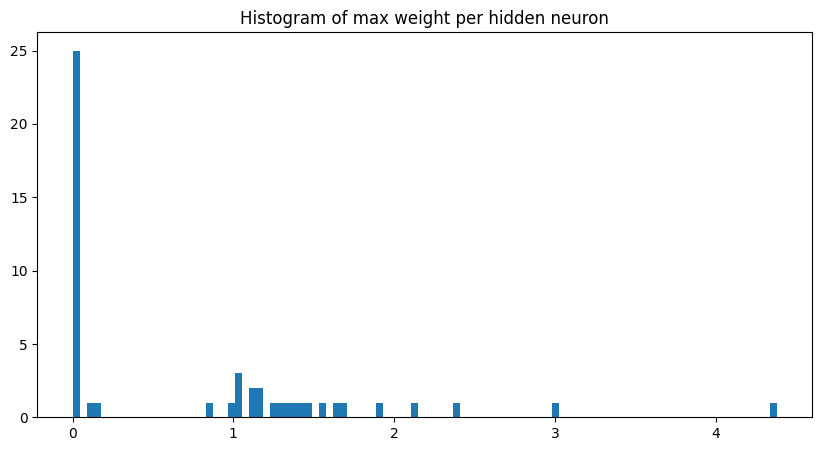

In [50]:
# how strongly does each hidden neuron influence *any* output?
plt.figure(figsize=(10,5))
plt.hist(np.abs(clf.coefs_[1]).max(axis=1), bins=100)
plt.title("Histogram of max weight per hidden neuron")
plt.show()

In [51]:
# count “extreme” neurons
print((np.abs(clf.coefs_[1]).max(axis=1)>1).sum())

21


In [52]:
# which neuron drives each class the most positively or negatively?
print("Most positive driver for each class:",
      clf.coefs_[1].argmax(axis=0))
print("Positive weight values:", 
      clf.coefs_[1].max(axis=0))

print("Most negative driver for each class:",
      clf.coefs_[1].argmin(axis=0))
print("Negative weight values:", 
      clf.coefs_[1].min(axis=0))

Most positive driver for each class: [23 23 19]
Positive weight values: [2.27320738 1.76854536 1.62071454]
Most negative driver for each class: [ 0  1 23]
Negative weight values: [-1.65905173 -3.02201459 -4.38258297]


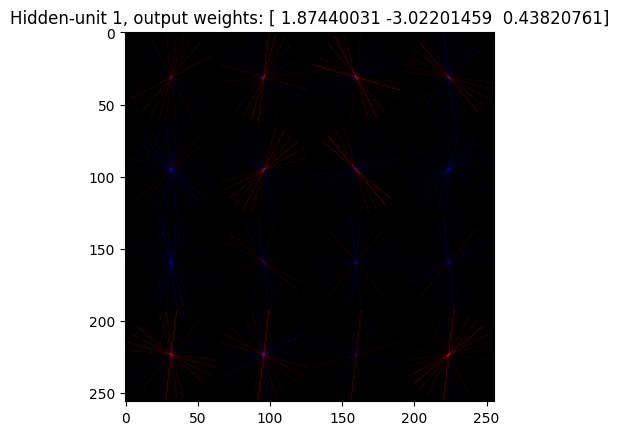

In [53]:
%matplotlib inline

# visualize the receptive field of hidden neuron i = 1
i = 1
hog = get_hog_image(
    clf.coefs_[0][:, i].reshape((4,4,16)),
    output_size=256
)
plt.imshow(hog / hog.max())
plt.title(f"Hidden-unit {i}, output weights: {clf.coefs_[1][i]}")
plt.show()

### What This Tells Us About the Network

- 25 hidden units have at least one outgoing weight with magnitude > 1.0. This tells us roughly half the hidden layer is “strongly wired” to affect the final decision, while the others play a more subdued role (neurons may saturate their activations).
- a relatively small subset of neurons carry the bulk of the decision-making weight, suggesting a **sparse, specialized representation**.
- if one feature has a much larger numeric range than another, its weights get updated with much larger steps, which can make training slow or unstable. Normalization ensures every dimension contributes roughly equally.
- by visualizing the `input→hidden` weights for those top driver units (using the HOG-image plot you made), it's possible to interpret which edge-orientation patterns the network deems most distinctive for airplanes, birds, and horses.

In [7]:
%%time

# define a StratifiedKFold splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# define the hyperparameter grid to search
param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,),    # 1‑layer nets
        (50,50), (100,50),# 2‑layer nets
        (100,100,50)      # 3‑layer net
    ],
    'activation':         ['relu'],
    'alpha':              [1e-4, 1e-3], 
    'learning_rate_init': [1e-3, 1e-2]
}

# set up and run a grid search over the above parameters
base_mlp = MLPClassifier(max_iter=300, random_state=0)
grid = GridSearchCV(
    base_mlp,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_scaled, y_train)

# report best results
print("\n--- Hyperparameter search results ---")
print("Best parameters: ", grid.best_params_)
print("Best architecture: ", grid.best_params_['hidden_layer_sizes'])
print("Best activation: ", grid.best_params_['activation'])
print("Best alpha: ", grid.best_params_['alpha'])
print("Best η₀: ", grid.best_params_['learning_rate_init'])
print(f"Best 5‑fold CV accuracy: {grid.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Hyperparameter search results ---
Best parameters:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Best architecture:  (100,)
Best activation:  relu
Best alpha:  0.001
Best η₀:  0.001
Best 5‑fold CV accuracy: 0.7937
CPU times: total: 19.5 s
Wall time: 1min 43s


In [37]:
%%time

# final model
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=300,
    random_state=0
)

# (re-)fit it on the *entire* training set
mlp.fit(X_train_scaled, y_train)

# predict on the test set
y_test_pred = mlp.predict(X_test_scaled)

# compute and print your final metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

print("--- Final Test-Set Performance ---")
print(f"Test accuracy: {test_acc:.4f}\n")
print("Confusion matrix:")
print(test_cm, "\n")
print("Classification report:")
print(classification_report(y_test, y_test_pred, target_names=dataset.labels))

--- Final Test-Set Performance ---
Test accuracy: 0.8000

Confusion matrix:
[[818 132  50]
 [108 755 137]
 [ 47 126 827]] 

Classification report:
              precision    recall  f1-score   support

    Airplane       0.84      0.82      0.83      1000
        Bird       0.75      0.76      0.75      1000
       Horse       0.82      0.83      0.82      1000

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000

CPU times: total: 20 s
Wall time: 11 s


## [EXTRA] CNN Test

### CNN with tensorflow

In [30]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# prepare the data: reshape + normalize + one-hot
X = dataset.train['images'].reshape(-1, 32, 32, 3).astype('float32') / 255.0
y = to_categorical(dataset.train['labels'], num_classes=3)

# split off a held-out validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=dataset.train['labels'], random_state=0
)

# define a simple CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# train
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=2
)

# evaluate on the validation set
y_val_pred_proba = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
y_val_true = np.argmax(y_val, axis=1)

acc = accuracy_score(y_val_true, y_val_pred)
cm = confusion_matrix(y_val_true, y_val_pred)

print(f"CNN validation accuracy: {acc:.4f}")
print("Confusion matrix:\n", cm)

Epoch 1/10


C:\Users\gianm\miniforge3\envs\test\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 - 4s - 23ms/step - accuracy: 0.6324 - loss: 0.8077 - val_accuracy: 0.7590 - val_loss: 0.5905
Epoch 2/10
188/188 - 2s - 10ms/step - accuracy: 0.7566 - loss: 0.5764 - val_accuracy: 0.7963 - val_loss: 0.5140
Epoch 3/10
188/188 - 2s - 10ms/step - accuracy: 0.7977 - loss: 0.4969 - val_accuracy: 0.8063 - val_loss: 0.4684
Epoch 4/10
188/188 - 2s - 10ms/step - accuracy: 0.8198 - loss: 0.4518 - val_accuracy: 0.8157 - val_loss: 0.4351
Epoch 5/10
188/188 - 2s - 10ms/step - accuracy: 0.8347 - loss: 0.4136 - val_accuracy: 0.8273 - val_loss: 0.4163
Epoch 6/10
188/188 - 2s - 10ms/step - accuracy: 0.8457 - loss: 0.3941 - val_accuracy: 0.8233 - val_loss: 0.4460
Epoch 7/10
188/188 - 2s - 10ms/step - accuracy: 0.8538 - loss: 0.3682 - val_accuracy: 0.8397 - val_loss: 0.3926
Epoch 8/10
188/188 - 2s - 10ms/step - accuracy: 0.8663 - loss: 0.3375 - val_accuracy: 0.8340 - val_loss: 0.3996
Epoch 9/10
188/188 - 2s - 10ms/step - accuracy: 0.8772 - loss: 0.3179 - val_accuracy: 0.8363 - val_loss: 0.4028
Epo

### CNN with torch

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# data
flat_images = dataset.train['images']                 # shape: (n_samples, 3072)
X = flat_images.reshape(-1, 32, 32, 3).astype('float32') / 255.0
y = dataset.train['labels'].astype(np.int64)

# convert to torch tensors and reorder to (N, 3, 32, 32)
X_tensor = torch.from_numpy(X).permute(0,3,1,2)
y_tensor = torch.from_numpy(y)

# split into train/val (80/20)
dataset_torch = TensorDataset(X_tensor, y_tensor)
n_train = int(len(dataset_torch) * 0.8)
n_val = len(dataset_torch) - n_train
train_ds, val_ds = random_split(dataset_torch, [n_train, n_val], generator=torch.Generator().manual_seed(0))

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# a simple CNN for classification
class SimpleCNNClassifier(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → (N,32,16,16)
        x = self.pool(F.relu(self.conv2(x)))  # → (N,64,8,8)
        x = x.view(x.size(0), -1)             # → (N,64*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNNClassifier().to(device)

# loss, optimizer, early stopping
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# training loop
max_epochs = 50
patience = 3
best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = "best_cnn.pth"

for epoch in range(1, max_epochs+1):
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    all_preds = []
    all_labels= []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            preds  = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    val_acc = accuracy_score(y_true, y_pred)

    print(f"Epoch {epoch}/{max_epochs}  Train loss: {train_loss:.4f}  Val acc: {val_acc:.4f}")

    # Early stopping on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(" New best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/50  Train loss: 0.7108  Val acc: 0.7703
 New best model saved.
Epoch 2/50  Train loss: 0.5430  Val acc: 0.7787
 New best model saved.
Epoch 3/50  Train loss: 0.4680  Val acc: 0.7967
 New best model saved.
Epoch 4/50  Train loss: 0.4228  Val acc: 0.8403
 New best model saved.
Epoch 5/50  Train loss: 0.3802  Val acc: 0.8463
 New best model saved.
Epoch 6/50  Train loss: 0.3447  Val acc: 0.8510
 New best model saved.
Epoch 7/50  Train loss: 0.3155  Val acc: 0.8663
 New best model saved.
Epoch 8/50  Train loss: 0.2900  Val acc: 0.8580
Epoch 9/50  Train loss: 0.2695  Val acc: 0.8587
Epoch 10/50  Train loss: 0.2525  Val acc: 0.8693
 New best model saved.
Epoch 11/50  Train loss: 0.2156  Val acc: 0.8603
Epoch 12/50  Train loss: 0.2034  Val acc: 0.8690
Epoch 13/50  Train loss: 0.1730  Val acc: 0.8620
Early stopping triggered.


In [ ]:
# load best model & final evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

# compute final val confusion matrix
all_preds = []
all_labels= []
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds  = torch.argmax(model(Xb), dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

print(f"\nFinal Validation Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)


Final Validation Accuracy: 0.8693
Confusion Matrix:
 [[892  64  37]
 [100 848  72]
 [ 24  95 868]]
